In [3]:
from google.colab import drive
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content
/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive
cityscapes_data  UNet-Colorizer.h5


In [11]:
import os
import keras
import numpy as np
from tqdm import tqdm
import cv2
from glob import glob
import tensorflow as tf

# Data
from keras.preprocessing.image import img_to_array, array_to_img

# Data Visualization
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
base = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive"

In [6]:
train_dir = os.path.join(base,'cityscapes_data/train')
test_dir = os.path.join(base, 'cityscapes_data/val')

Examining dataset

In [7]:
print("Training Directory Contents:")
print(os.listdir(train_dir))

print("Test Directory Contents:")
print(os.listdir(test_dir))

Training Directory Contents:
['1255.jpg', '1254.jpg', '1252.jpg', '1256.jpg', '1257.jpg', '1253.jpg', '1250.jpg', '1251.jpg', '1249.jpg', '1226.jpg', '1237.jpg', '1215.jpg', '1219.jpg', '1218.jpg', '1216.jpg', '1222.jpg', '1209.jpg', '121.jpg', '1210.jpg', '1211.jpg', '1207.jpg', '1208.jpg', '123.jpg', '1232.jpg', '1230.jpg', '1233.jpg', '1231.jpg', '1228.jpg', '124.jpg', '1241.jpg', '1238.jpg', '1240.jpg', '1243.jpg', '1223.jpg', '1245.jpg', '1235.jpg', '1205.jpg', '1244.jpg', '1242.jpg', '1220.jpg', '1221.jpg', '122.jpg', '1246.jpg', '1248.jpg', '1217.jpg', '1214.jpg', '1206.jpg', '1247.jpg', '1212.jpg', '1224.jpg', '1213.jpg', '1239.jpg', '125.jpg', '1236.jpg', '133.jpg', '1332.jpg', '1330.jpg', '1325.jpg', '1324.jpg', '1326.jpg', '1328.jpg', '1329.jpg', '1327.jpg', '1322.jpg', '1323.jpg', '1320.jpg', '1319.jpg', '1321.jpg', '132.jpg', '1316.jpg', '1315.jpg', '1314.jpg', '1313.jpg', '1317.jpg', '1318.jpg', '1312.jpg', '1311.jpg', '131.jpg', '1308.jpg', '1310.jpg', '1309.jpg', '1303.

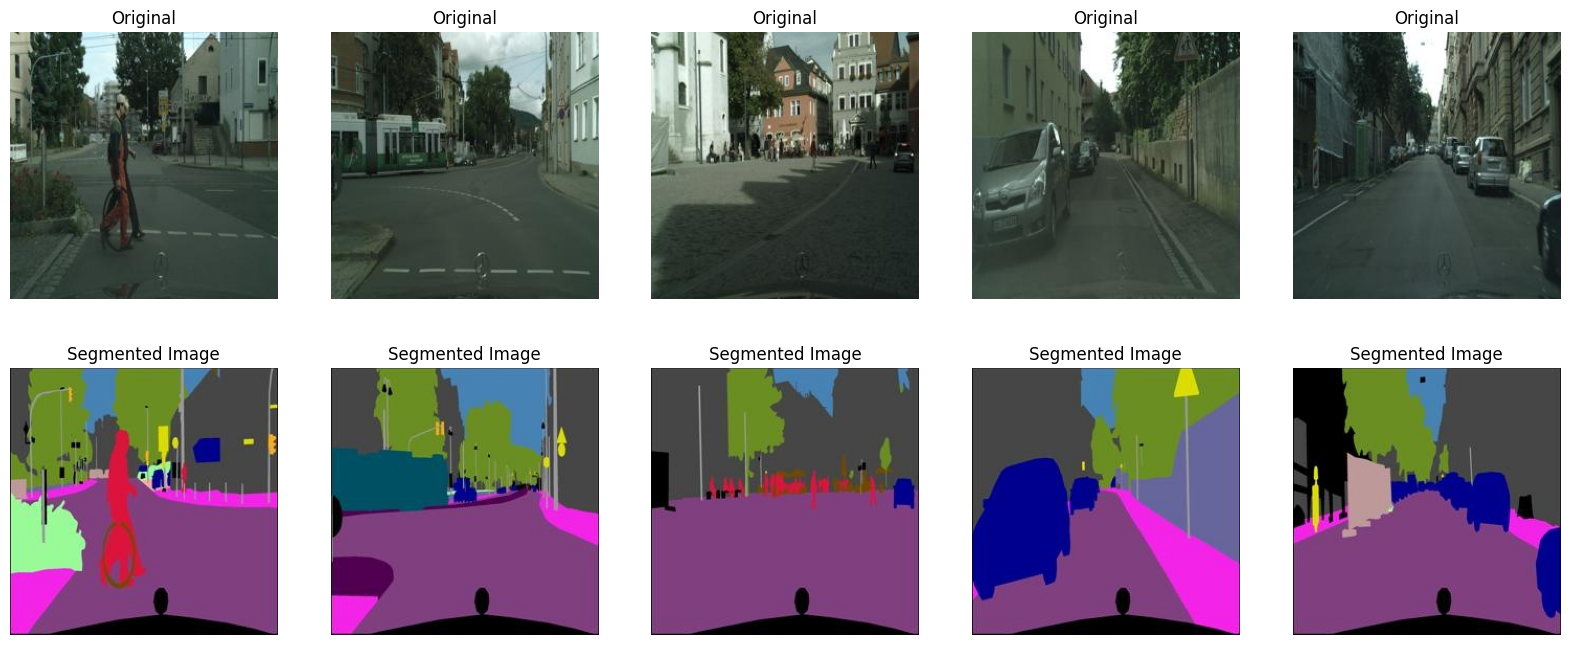

In [8]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get a list of all image file paths in the train_dir
image_files = glob(os.path.join(train_dir, '*.jpg'))

# Select 5 random images
random_images = random.sample(image_files, 5)

# Display the selected images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, image_path in enumerate(random_images):
    img = mpimg.imread(image_path)
    original_img, segmented_img = np.hsplit(img, 2)  # Split the image into two halves

    # Show the original image
    axes[0, i].imshow(original_img)
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    # Show the segmented image
    axes[1, i].imshow(segmented_img)
    axes[1, i].axis('off')
    axes[1, i].set_title('Segmented Image')

plt.show()

Import libraries

Data Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Load the training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode=None,
        seed=42)

# Load the validation data (no augmentation needed)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode=None,
        seed=42)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


# Preprocessing

- Resizing Images and Masks
Resizing the images and masks to a consistent size
- Color Conversion:
The color space of the images is converted from BGR (OpenCV default) to RGB using cv.cvtColor(image, cv.COLOR_BGR2RGB).
- Normalization:
The pixel values of the images and masks are normalized by dividing by 255.0.
- Data Splitting:
The code splits each image into two parts: the left half for the image and the right half for the mask.This is done because in this particular dataset the left side of the image corresponds to the original photo and the right portion of the image corresponds to the segmentation mask.

In [13]:
# Set the desired size of your images and masks
SIZE = 192

# Set the paths for saving images and masks
image_save_path = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/images"
mask_save_path = "/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/masks"

# Create the directories if they don't exist
os.makedirs(image_save_path, exist_ok=True)
os.makedirs(mask_save_path, exist_ok=True)

# Initialize empty lists to store images and masks
images = []
masks = []

for i in tqdm(range(len(image_files))):
    path = image_files[i]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')

    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))

    # Convert the TensorFlow tensors to NumPy arrays
    img_np = img.numpy()
    mask_np = mask.numpy()

    # Append the resized image and mask to the lists
    images.append(img_np)
    masks.append(mask_np)

    # Save the image
    image_filename = os.path.join(image_save_path, f"image_{i}.jpg")
    cv2.imwrite(image_filename, img_np * 255)

    # Save the mask
    mask_filename = os.path.join(mask_save_path, f"mask_{i}.jpg")
    cv2.imwrite(mask_filename, mask_np * 255)

# Split the data into training and validation sets
X_train = images[:2900]
y_train = masks[:2900]

X_valid = images[2900:]
y_valid = masks[2900:]

100%|██████████| 2975/2975 [02:29<00:00, 19.96it/s]


# Working with the model


Define the model


## Saving the model

In [ ]:
# model.save('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/unet_model')
# model.save_weights('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data/unet_model.h5')

# Evaluating the model

In [ ]:
# import matplotlib.pyplot as plt

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# Utilizing Model

First we should load the model

In [ ]:
# new_model = keras.models.load_model('/content/gdrive/MyDrive/Desarrollo de Aplicaciones/AI_Project/archive/cityscapes_data')